# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [216]:
%matplotlib inline
import pandas as pd
from sklearn.cluster import KMeans,AffinityPropagation,SpectralClustering,AgglomerativeClustering,DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
# DataFrame Merging

df_merge = df_offers.merge(df_transactions, left_on='offer_id', right_on='offer_id', how='left')
print(len(df_merge))
df_merge.head()

324


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [7]:
# Pivot_Table

df_offer_details = pd.pivot_table(df_merge, values = 'n', index = ['customer_name'], columns = ['offer_id'], fill_value = 0)

print(len(df_offer_details))
df_offer_details.reset_index(inplace = True)
df_offer_details.head()

100


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [ ]:
# SS is measurement of distance between data point and centroid. For better clustering , this distance should be
# minimum. Though, finding SS is difficult task and completely depends on the type of available data. 

In [41]:
# Creating numpy matrix

x_cols = df_offer_details.iloc[:,2:33].to_numpy()
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

Text(0.5, 1.0, 'Clusters between 2 to 10')

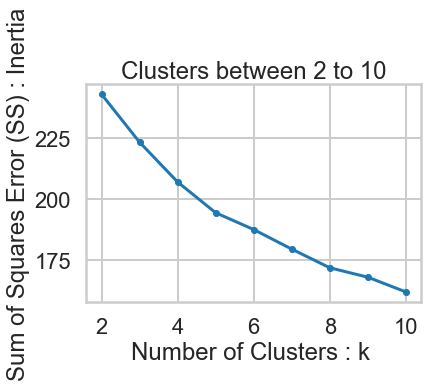

In [34]:
from sklearn.cluster import KMeans

k_range = range(2,11)
kmeans_ss = [KMeans( n_clusters = k, random_state = 5 ).fit(x_cols).inertia_ for k in k_range]

# Graph Plotting

fig = plt.figure()
_ = fig.add_subplot(111)
_.plot(k_range, kmeans_ss,".-")
# _.set_ylim(100,300)
#_.set_ylim(150,250)
plt.xlabel('Number of Clusters : k ')
plt.ylabel('Sum of Squares Error (SS) : Inertia')
plt.title('Clusters between 2 to 10')

dict_keys([1, 0, 4, 2, 3])


dict_values([35, 22, 17, 17, 9])




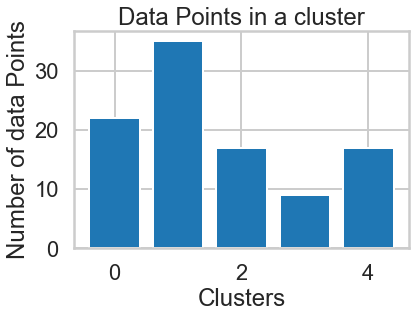

In [35]:
# Using 'Elbow Method' , K should be 5

final_k = 5

kmeans  = KMeans(n_clusters = final_k,random_state=42)
df_offer_details['cluster'] = kmeans.fit_predict(x_cols)

dict_cluster = df_offer_details.cluster.value_counts().to_dict()


plt.bar(dict_cluster.keys(), dict_cluster.values())
plt.xlabel('Clusters')
plt.ylabel('Number of data Points')
plt.title('Data Points in a cluster')
print(dict_cluster.keys())
print('\n')
print(dict_cluster.values())
print('\n')

In [ ]:
# Elbow method provides a good insight to predict K. But , here for the given example, a very little bend 
# can be seen in the graph.Thus, it is little bit confusing which K should be used. I have choosen k= 5, 
# but it seems that k = 4 or 6 will also work in same way. Hence, Its always good to use atleast two method 
# to identify k value. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09467039888175721
For n_clusters = 3 The average silhouette_score is : 0.12435687906779831
For n_clusters = 4 The average silhouette_score is : 0.10621743538339512
For n_clusters = 5 The average silhouette_score is : 0.147526815597879
For n_clusters = 6 The average silhouette_score is : 0.1210322727880898
For n_clusters = 7 The average silhouette_score is : 0.13526470702979365
For n_clusters = 8 The average silhouette_score is : 0.11806245461314173
For n_clusters = 9 The average silhouette_score is : 0.11884325671281097
For n_clusters = 10 The average silhouette_score is : 0.10326267746039294


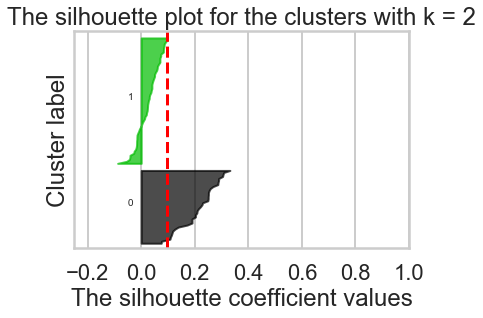

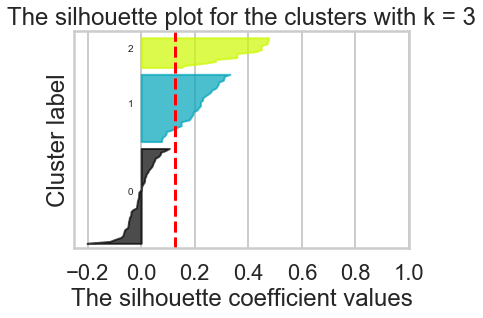

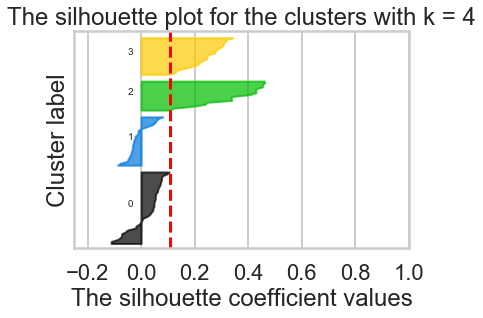

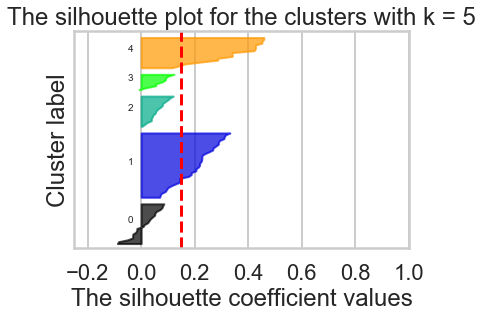

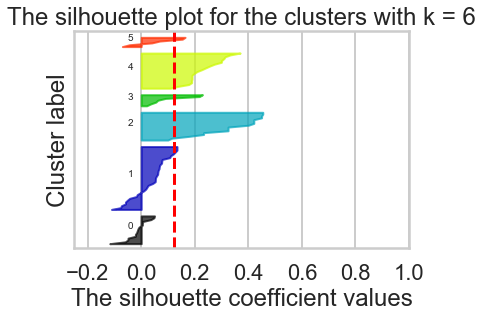

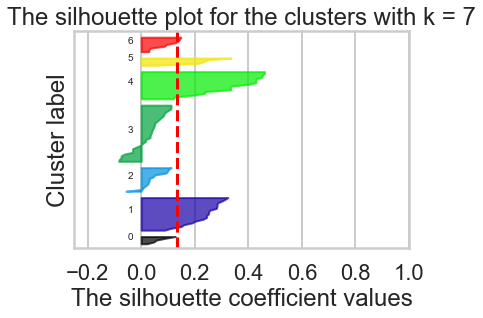

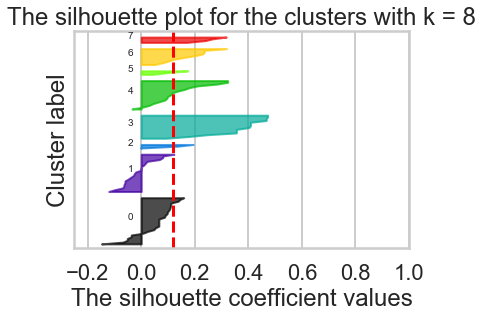

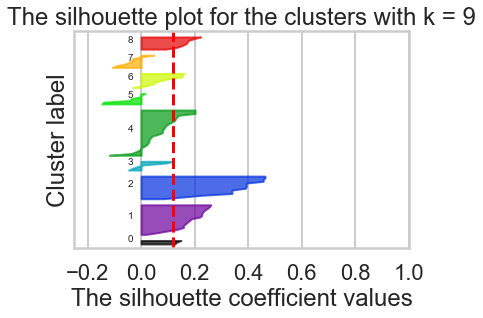

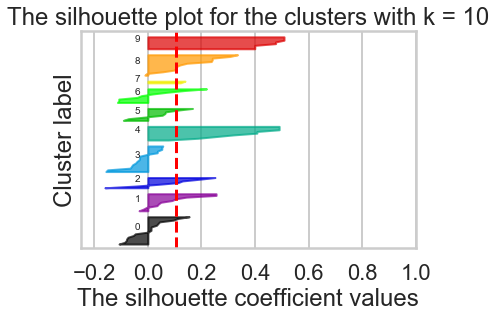

In [36]:
# silhouette_score` function 



from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np




range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
   
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.25, 0.6])
    # The (n_clusters+1)*2.5 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 2.5])

    y_lower = 2.5
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 2.5  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the clusters with k = %d" %n_clusters)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]) 

   

plt.show()

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [200]:
# Applying PCA

pca1 = PCA(n_components = 2,random_state=42)

factors = pca.fit_transform(x_cols)

In [45]:
# Add 2 PCA components into DataFrame

df_name = pd.DataFrame(df_offer_details.iloc[:,0])

df_x_y = pd.DataFrame(factors,columns = ['x','y'])

list_combo = [df_name,df_x_y]

df_name_x_y = pd.concat(list_combo,axis = 1)
print(df_name_x_y.head())

# add cluster labels using the same k-range as used above
for k in k_range:
    
    # calculate cluster labels

    clusterer = KMeans( n_clusters = k, random_state = 42 )
    cluster_labels = clusterer.fit_predict(factors)
    
    # append labels to dataframe
    df_name_x_y[str('clusters_' + str(k))] = cluster_labels

print(df_name_x_y.head())


  customer_name         x         y
0         Adams  1.014908  0.157764
1         Allen -0.313043  0.019268
2      Anderson -0.451462  1.008114
3        Bailey  0.700551  0.006002
4         Baker  0.072574 -0.494352
  customer_name         x         y  clusters_2  clusters_3  clusters_4  \
0         Adams  1.014908  0.157764           0           1           0   
1         Allen -0.313043  0.019268           1           0           3   
2      Anderson -0.451462  1.008114           1           2           1   
3        Bailey  0.700551  0.006002           0           1           0   
4         Baker  0.072574 -0.494352           1           0           2   

   clusters_5  clusters_6  clusters_7  clusters_8  clusters_9  clusters_10  
0           3           4           5           4           4            6  
1           4           1           4           5           3            2  
2           0           3           2           3           2            5  
3           1           0

In [ ]:
# Creating the scatterplots

# setup figure and fill with data
fig = plt.figure()
for k in K_value:    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)

    ax.set_xticks([])
    ax.set_yticks([])
    
    # fill data in the scatterplots
    plt.scatter(x = df_name_x_y['x'], y = df_name_x_y['y'],s=20,
                c=df_name_x_y.iloc[:,k+1],cmap = 'Set2')
    ax.set_title('Clusters for k = ' + str(k),fontsize=10)

    

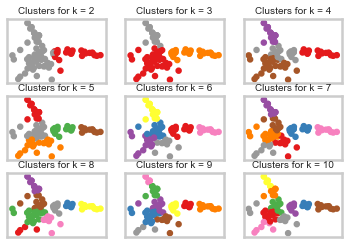

In [50]:
# Creating Scatterplots


# setup figure and fill with data
fig = plt.figure()
for k in k_range:    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # fill data in the scatterplots
    plt.scatter(x = df_name_x_y['x'], y = df_name_x_y['y'], s = 20,
                c = df_name_x_y.iloc[:,k + 1], cmap = 'Set1')
    ax.set_title('Clusters for k = ' + str(k),fontsize=10)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

### Creating dataframe for storytelling part

In [130]:

df_cluster = df_offer_details[['customer_name','cluster']]

clusterLabeled_offer_customers = df_merge.merge(df_cluster, how = 'left', left_on = 'customer_name',
                                                right_on = 'customer_name')
print(clusterLabeled_offer_customers)


     offer_id  campaign            varietal  min_qty  discount   origin  \
0           1   January              Malbec       72        56   France   
1           1   January              Malbec       72        56   France   
2           1   January              Malbec       72        56   France   
3           1   January              Malbec       72        56   France   
4           1   January              Malbec       72        56   France   
..        ...       ...                 ...      ...       ...      ...   
319        31  December           Champagne       72        89   France   
320        32  December  Cabernet Sauvignon       72        45  Germany   
321        32  December  Cabernet Sauvignon       72        45  Germany   
322        32  December  Cabernet Sauvignon       72        45  Germany   
323        32  December  Cabernet Sauvignon       72        45  Germany   

     past_peak customer_name  n  cluster  
0        False        Thomas  1        3  
1        Fals

### Clusters analysis by campaign-month

In [131]:
# Converting name of month into respective integer

d = {"January":1,"February":2,"March":3,"April":4,"May":5, 
      "June":6,"July":7,"August":8,"September":9,"October":10,"November":11, "December":12}


clusterLabeled_offer_customers.campaign = clusterLabeled_offer_customers.campaign.map(d)

clusterLabeled_offer_customers.head()


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster
0,1,1,Malbec,72,56,France,False,Thomas,1,3
1,1,1,Malbec,72,56,France,False,Jackson,1,2
2,1,1,Malbec,72,56,France,False,Mitchell,1,4
3,1,1,Malbec,72,56,France,False,Peterson,1,4
4,1,1,Malbec,72,56,France,False,Wood,1,3


In [132]:
clusterLabeled_offer_customers.campaign.value_counts().sort_index()

1     20
2     22
3     51
4     17
5     24
6     20
7     26
8     31
9     17
10    30
11    23
12    43
Name: campaign, dtype: int64

In [174]:

cmp_cluster = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'campaign']).size())
cmp_cluster.columns=['value']

print(cmp_cluster.head())


                  value
cluster campaign       
0       1             2
        2            10
        3             6
        4             8
        5             7


In [175]:
# using unstack function will give us details about
# total number of offers per month in a particular cluster

print(cmp_cluster.unstack())

         value                                                                
campaign    1     2     3    4    5     6     7     8     9     10    11    12
cluster                                                                       
0          2.0  10.0   6.0  8.0  7.0   5.0   2.0   6.0   1.0   9.0   4.0  13.0
1          NaN   1.0  32.0  2.0  8.0   NaN  13.0   1.0   NaN   1.0  17.0  17.0
2          6.0   7.0  11.0  2.0  7.0   2.0   4.0  19.0   NaN   4.0   2.0  10.0
3          3.0   4.0   2.0  4.0  1.0  12.0   NaN   5.0   3.0   3.0   NaN   3.0
4          9.0   NaN   NaN  1.0  1.0   1.0   7.0   NaN  13.0  13.0   NaN   NaN


In [176]:
# convert all NaN values with zero(0)
cmp_cluster.unstack().fillna(0)

value                                                                
campaign    1     2     3    4    5     6     7     8     9     10    11    12
cluster                                                                       
0          2.0  10.0   6.0  8.0  7.0   5.0   2.0   6.0   1.0   9.0   4.0  13.0
1          0.0   1.0  32.0  2.0  8.0   0.0  13.0   1.0   0.0   1.0  17.0  17.0
2          6.0   7.0  11.0  2.0  7.0   2.0   4.0  19.0   0.0   4.0   2.0  10.0
3          3.0   4.0   2.0  4.0  1.0  12.0   0.0   5.0   3.0   3.0   0.0   3.0
4          9.0   0.0   0.0  1.0  1.0   1.0   7.0   0.0  13.0  13.0   0.0   0.0

C:\Users\vyasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


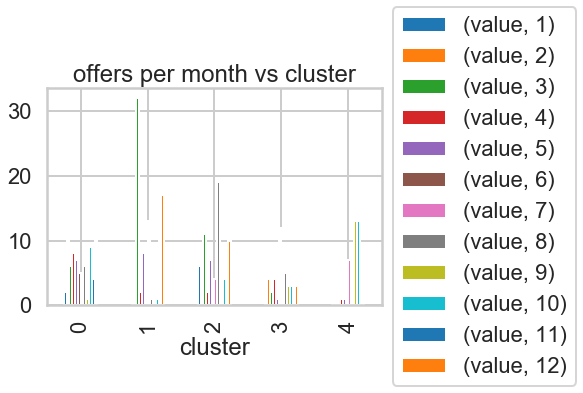

In [187]:
# Graph Plotting

fig = cmp_cluster.unstack().fillna(0).plot(kind='bar',legend=False,title = 'offers per month vs cluster')
ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




### Cluster analysis by varietal

In [196]:
var_cluster = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'varietal']).size())
var_cluster.columns=['value']
print(var_cluster.head())

                            value
cluster varietal                 
0       Cabernet Sauvignon     18
        Champagne              29
        Chardonnay              8
        Espumante               2
        Malbec                  2


C:\Users\vyasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


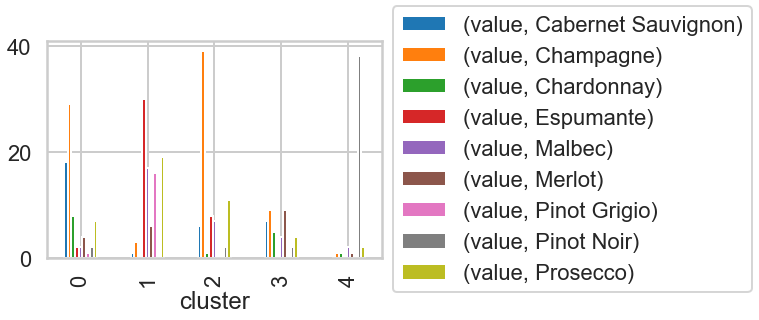

In [197]:
# Graph Plotting

fig = var_cluster.unstack().plot(kind='bar',legend=False)
ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Cluster analysis by origin

In [198]:
org_cluster = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'origin']).size())
org_cluster.columns=['value']
print(org_cluster.head())

                    value
cluster origin           
0       Australia       3
        California      6
        Chile          11
        France         29
        Germany         5


C:\Users\vyasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


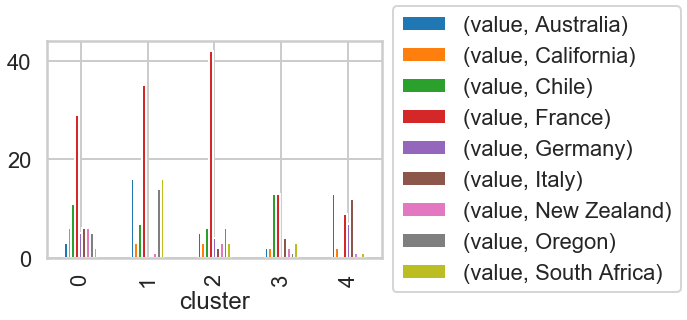

In [199]:
# Graph Plotting

fig = org_cluster.unstack().plot(kind='bar',legend=False)
ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

If we look at the above charts, we can see that clusters were strongly distinguished by following : 

- varietals
- months
- country of origin

**Story of Clusters:**

**Cluster 0** - Showed strong preference for champagne and Cabernate. All months have an average 8-10 offers.Popular origin                 is France.
**Cluster 1** - Showed a strong preference for Espumante. Most popular months were March and December. Preferred country of                 origin being France.

**Cluster 2** - Pinot Noir was the most popular varietal for this group. Country of origins preferred were France.
                Campaign months were FEbruary, March and August.

**Cluster 3** - This group displayed a near equal preference for Champagne and Marlot. IN this cluster all months are less                 populer as comapred to others.Preferred countries of origin being France and Chile.

**Cluster 4** - This group had a strong preference for Pinot noir. Country of origin preferred was Chile and Itely most                     popular campaign months being MArch and July.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0.5, 1.0, 'Variance Explained vs. Components')

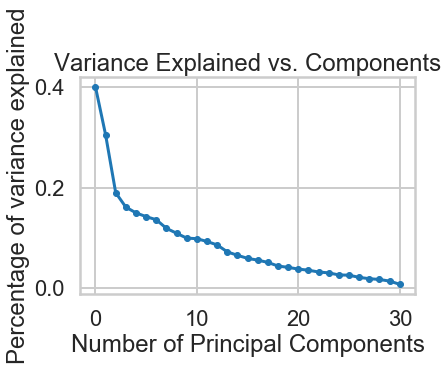

In [201]:
# Initialize a new PCA model with a default number of components.

pca = PCA()
pca_factors = pca.fit(x_cols)

# PLot the curve tto analyze 'Elbow-Curve'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_factors.explained_variance_, '.-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. Components')


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity propagation

In [208]:
# for Affinity propagation, we dont require number of clusters. 
# It takes damping value.


# creating range of damping values

d_range = np.arange(0.5,1.0,0.05)

for d in d_range:
       
    affinity = AffinityPropagation(damping=d)
    affinity_labels = affinity.fit_predict(x_cols)

    # Average value by silhouette_score 
    
    silhouette_avg = silhouette_score(x_cols, affinity_labels)
    print("For d = %.2f the average silhouette_score: %.5f " %(d,silhouette_avg))
    print("Number of Cluster Centers (Count of Indices):", len(affinity.cluster_centers_))
    print('\n')

For d = 0.50 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.55 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.60 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.65 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.70 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.75 the average silhouette_score: 0.12768 
Number of Cluster Centers (Count of Indices): 17


For d = 0.80 the average silhouette_score: 0.11032 
Number of Cluster Centers (Count of Indices): 16


For d = 0.85 the average silhouette_score: 0.09355 
Number of Cluster Centers (Count of Indices): 15


For d = 0.90 the average silhouette_score: 0.09355 
Number of Cluster Centers (Count of Indices): 15


For d = 0.95 the average silhouette_score: 0.02291 
Number of Cluster Cen

### Spectral clustering

In [211]:
# for this method, number of clusters should be known in advance

for k in k_range:
    spectra  = SpectralClustering( n_clusters = k, random_state = 42 )
    spectra_labels = spectra.fit_predict(x_cols)
    
    # obtain and report silhouette scores
    silht_avg = silhouette_score(x_cols, spectra_labels)
    print("For k = %.0f the average silhouette score: %.4f" % (k, silht_avg))
    print('\n')

For k = 2 the average silhouette score: 0.0794


For k = 3 the average silhouette score: 0.1204


For k = 4 the average silhouette score: 0.0917


For k = 5 the average silhouette score: 0.1107


For k = 6 the average silhouette score: 0.1064


For k = 7 the average silhouette score: 0.0805


For k = 8 the average silhouette score: 0.0942


For k = 9 the average silhouette score: 0.0939


For k = 10 the average silhouette score: 0.0979




### Aglomerative Clustering

In [215]:
for k in k_range:
    agglo  = AgglomerativeClustering( n_clusters = k )
    agglo_labels = agglo.fit_predict(x_cols)
    
    # obtain and report silhouette scores
    s_avg = silhouette_score(x_cols, agglo_labels)
    print("For k = %.0f the average silhouette score: %.4f" % (k, s_avg))
    print('\n')

For k = 2 the average silhouette score: 0.0881


For k = 3 the average silhouette score: 0.1186


For k = 4 the average silhouette score: 0.1309


For k = 5 the average silhouette score: 0.1416


For k = 6 the average silhouette score: 0.1513


For k = 7 the average silhouette score: 0.1199


For k = 8 the average silhouette score: 0.1245


For k = 9 the average silhouette score: 0.1328


For k = 10 the average silhouette score: 0.1292




### DBSCAN

In [222]:

eps_range =[0.2,0.6,1,2,4,5]
for eps in eps_range:
    
    dbscan = DBSCAN(eps=eps)
    dbscan_labels = dbscan.fit_predict( x_cols )
    print("EPS output: %.2f" % eps)
    print(dbscan_labels)
    print("\n")   
    
min_s_range = [1,2,3]

for s in min_s_range:
    dbscan2 = DBSCAN( min_samples = s )
    dbscan2_labels = dbscan2.fit_predict(x_cols)
    
    slht_avg = silhouette_score(x_cols, dbscan2_labels)
    print("For min_samples = %.0f, the average silhouette scores is %.4f." % (s, slht_avg))
    print("No. of Core Sample Indices:", len(dbscan2.core_sample_indices_))
    print("\n")

EPS output: 0.20
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


EPS output: 0.60
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


EPS output: 1.00
[ 0 -1  1  2 -1 -1  1  2 -1  2 -1  1  2 -1 -1  1 -1  1  0 -1  2  2 -1 -1
  1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1  2 -1 -1  1  1  2 -1 -1 -1  2 -1
 -1 -1 -1 -1 -1  1 -1  2  1  3  0 -1 -1  2 -1  0  0 -1  1 -1 -1 -1 -1 -1
 -1  3 -1  2  1 -1 -1  1 -1 -1 -1  1  2 -1  0 -1 -1  2 -1  0 -1  2 -1 -1
  2 -1 -1 -1]


EPS output: 2.00
[ 0  0  